In [ ]:
#DISTANCE PREDCITION AND DISTANCE FEATURE IMPORTANCE]
#//////////////////////////////////////////
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator

# Function to load and combine data
def load_combined_data(base_path, filenames, throw_name):
    data_frames = []
    for file in filenames:
        file_path = os.path.join(base_path, file)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, header=None)
            feature_name = os.path.splitext(os.path.basename(file))[0]
            # Avoid redundant labels and ensure uniqueness
            headers = df.iloc[:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
            if df.iloc[0, 1] == 0.0:
                headers = df.iloc[1:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
                data = df.iloc[1:, 1:].transpose().reset_index(drop=True)
            else:
                data = df.iloc[:, 1:].transpose().reset_index(drop=True)
            data.columns = headers
            data_frames.append(data)
    combined_data = pd.concat(data_frames, axis=1)
    return combined_data

def combine_data_for_all_throws(base_paths, filenames):
    combined_data = {}
    for path in base_paths:
        throw_name = os.path.basename(os.path.dirname(path))
        combined_data[throw_name] = load_combined_data(path, filenames, throw_name)
    return combined_data

# Define base paths, throw distances, and feature groups as before
base_paths = [
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin25/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin50/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin75/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin100/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave25/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave50/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave75/Results"
]

# Define throw distances (target variable)
throw_distances = {
    'Javelin25': 71,
    'Javelin50': 102.5,
    'Javelin75': 121,
    'Javelin100': 131,
    'TRJave25': 41,
    'TRJave50': 46,
    'TRJave75': 50,
}

# Define feature groups
feature_groups = {
    'All': [
        'COP_labels_combined_with_COP.csv',
        'GRF_labels_combined_with_GRF_BW.csv',
        'GRM_labels_combined_with_GRM_BWht.csv',
        'KAM_labels_combined_with_KAM_BWht.csv',
        'MCF_labels_combined_with_MCF_BW.csv',
        'muscles_combined_with_muscle_forces.csv',
        'muscles_combined_with_muscle_activations.csv',
        'coordinates_combined_with_coordinate_speeds.csv',
        'coordinates_combined_with_coordinate_accelerations.csv',
        'torques_BWht.csv',
        'coordinate_values.csv',
        'powers.csv'
    ]
}

# Load and preprocess the data for 'All' feature group
all_data = combine_data_for_all_throws(base_paths, feature_groups['All'])

# Clean the DataFrame by ensuring all column names are unique and converting to numeric values
def clean_dataframe(df):
    # Convert all columns to numeric, coercing errors to NaN and dropping non-numeric columns
    numeric_df = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
    
    # Ensure all column names are unique by appending a suffix where necessary
    numeric_df.columns = pd.Index(
        [f"{col}_{i}" if list(numeric_df.columns).count(col) > 1 else col for i, col in enumerate(numeric_df.columns)]
    )
    
    return numeric_df

# Replace the problematic section in your code
all_data_list = []
for throw_name, temp_data in all_data.items():
    if throw_name not in throw_distances:
        print(f"Throw name {throw_name} not found in throw distances.")
    temp_data['distance'] = throw_distances.get(throw_name, np.nan)  # Add the target distance
    cleaned_data = clean_dataframe(temp_data)
    all_data_list.append(cleaned_data)

# Concatenate the cleaned data
all_data_combined = pd.concat(all_data_list, axis=0, ignore_index=True)

# Separate features and target variable
X_all = all_data_combined.drop(columns=['distance'], errors='ignore')
y_all = all_data_combined['distance']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_all_imputed = pd.DataFrame(imputer.fit_transform(X_all), columns=X_all.columns)

# Normalize features
scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all_imputed), columns=X_all_imputed.columns)

# Perform RFECV with XGBoost
xgb_model = XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=100)
rfecv = RFECV(estimator=xgb_model, step=50, cv=5, scoring='r2')
rfecv.fit(X_all_scaled, y_all)

# Get the selected features
selected_features = X_all.columns[rfecv.get_support()]

# Transform the dataset with selected features
X_selected = rfecv.transform(X_all_scaled)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_all, test_size=0.2, random_state=42)

# Define the models for stacking
nn_model = MLPRegressor(alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.1)
stacking_model = StackingRegressor(estimators=[('xgb', xgb_model), ('nn', nn_model)], final_estimator=XGBRegressor())

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Evaluate the model
y_pred = stacking_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Feature importance from XGBoost
xgb_model.fit(X_train, y_train)
xgb_importance = xgb_model.feature_importances_

# Feature importance from Neural Network (using coefficients from the first layer)
nn_model.fit(X_train, y_train)
nn_importance = np.abs(nn_model.coefs_[0]).sum(axis=1)

# Combine feature importances
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'XGBoost Importance': xgb_importance,
    'Neural Network Importance': nn_importance
})
feature_importance['XGBoost Importance'] /= feature_importance['XGBoost Importance'].sum()
feature_importance['Neural Network Importance'] /= feature_importance['Neural Network Importance'].sum()
feature_importance['Average Importance'] = feature_importance[['XGBoost Importance', 'Neural Network Importance']].mean(axis=1)

# Identify top features
top_features = feature_importance.sort_values(by='Average Importance', ascending=False).head(10)
print("Top features to optimize for maximizing throw distance:")
print(top_features)

In [ ]:
#GRF PREDCITION AND GRF FEATURE IMPORTANCE (EXSPENSIVE, 53%)
#//////////////////////////////////////////
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import os

# Function to load and combine data
def load_combined_data(base_path, filenames, throw_name):
    data_frames = []
    for file in filenames:
        file_path = os.path.join(base_path, file)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, header=None)
            feature_name = os.path.splitext(os.path.basename(file))[0]
            # Handling the specific format of the GRF file
            if feature_name == 'GRF_labels_combined_with_GRF_BW':
                # Assuming first row contains feature names and data starts from second row
                headers = df.iloc[:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
                data = df.iloc[:, 1:].transpose().reset_index(drop=True)
                data.columns = headers
            else:
                headers = df.iloc[:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
                if df.iloc[0, 1] == 0.0:
                    headers = df.iloc[1:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
                    data = df.iloc[1:, 1:].transpose().reset_index(drop=True)
                else:
                    data = df.iloc[:, 1:].transpose().reset_index(drop=True)
                data.columns = headers
            data_frames.append(data)
    combined_data = pd.concat(data_frames, axis=1)
    return combined_data

def combine_data_for_all_throws(base_paths, filenames):
    combined_data = {}
    for path in base_paths:
        throw_name = os.path.basename(os.path.dirname(path))
        combined_data[throw_name] = load_combined_data(path, filenames, throw_name)
    return combined_data

# Clean the DataFrame by ensuring all column names are unique and converting to numeric values
def clean_dataframe(df):
    # Convert all columns to numeric, coercing errors to NaN and dropping non-numeric columns
    numeric_df = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
    
    # Ensure all column names are unique by appending a suffix where necessary
    numeric_df.columns = pd.Index(
        [f"{col}_{i}" if list(numeric_df.columns).count(col) > 1 else col for i, col in enumerate(numeric_df.columns)]
    )
    
    return numeric_df

# Define base paths and feature groups
base_paths = [
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin25/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin50/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin75/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin100/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave25/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave50/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave75/Results"
]

feature_groups = {
    'All': [
        'COP_labels_combined_with_COP.csv',
        'GRF_labels_combined_with_GRF_BW.csv',
        'KAM_labels_combined_with_KAM_BWht.csv',
        'MCF_labels_combined_with_MCF_BW.csv',
        'muscles_combined_with_muscle_forces.csv',
        'muscles_combined_with_muscle_activations.csv',
        'coordinates_combined_with_coordinate_speeds.csv',
        'coordinates_combined_with_coordinate_accelerations.csv',
        'torques_BWht.csv',
        'coordinate_values.csv',
        'powers.csv'
    ],
    'Torques_and_Powers': [
        'torques_BWht.csv',
        'powers.csv'
    ],
    'Muscles_and_Forces': [
        'muscles_combined_with_muscle_forces.csv',
        'muscles_combined_with_muscle_activations.csv'
    ],
    'Kinematics': [
        'coordinates_combined_with_coordinate_speeds.csv',
        'coordinates_combined_with_coordinate_accelerations.csv'
    ]
}

feature_combinations = {
    'All': feature_groups['All'],
    'Torques_and_Powers': feature_groups['Torques_and_Powers'],
    'Muscles_and_Forces': feature_groups['Muscles_and_Forces'],
    'Kinematics': feature_groups['Kinematics'],
    'Torques_Powers_Kinematics': feature_groups['Torques_and_Powers'] + feature_groups['Kinematics'],
    'Muscles_Forces_Kinematics': feature_groups['Muscles_and_Forces'] + feature_groups['Kinematics']
}

# Optuna objective function
def objective(trial):
    # Hyperparameters for XGBoost
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    # Hyperparameters for MLP
    mlp_params = {
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50, 50), (100, 50), (100, 100)]),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.001, 0.1),
    }
    
    results = []
    for name, feature_files in feature_combinations.items():
        print(f"\nEvaluating feature combination: {name}")

        # Load the data for each combination
        all_data = combine_data_for_all_throws(base_paths, feature_files)
        
        # Clean the DataFrame by ensuring all column names are unique and converting to numeric values
        all_data_list = []
        for throw_name, temp_data in all_data.items():
            cleaned_data = clean_dataframe(temp_data)
            all_data_list.append(cleaned_data)

        # Concatenate the cleaned data
        all_data_combined = pd.concat(all_data_list, axis=0, ignore_index=True)

        # Separate features and target variable
        X_all = all_data_combined.drop(columns=[col for col in all_data_combined.columns if 'ground_force' in col], errors='ignore')
        y_grf = all_data_combined[[col for col in all_data_combined.columns if 'ground_force' in col]]

        if y_grf.empty:
            print("y_grf is empty after filtering. Please check if 'ground_force' columns are correctly identified.")
            print("Available columns:", all_data_combined.columns)
            continue

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X_all_imputed = pd.DataFrame(imputer.fit_transform(X_all), columns=X_all.columns)
        y_grf_imputed = pd.DataFrame(imputer.fit_transform(y_grf.values), columns=y_grf.columns)

        # Normalize features
        scaler = StandardScaler()
        X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all_imputed), columns=X_all_imputed.columns)
        y_grf_scaled = pd.DataFrame(scaler.fit_transform(y_grf_imputed), columns=y_grf_imputed.columns)

        # Split data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_all_scaled, y_grf_scaled, test_size=0.2, random_state=42)

        # Define the models for stacking
        xgb_model = XGBRegressor(**xgb_params)
        nn_model = MLPRegressor(**mlp_params)
        stacking_model = MultiOutputRegressor(StackingRegressor(estimators=[('xgb', xgb_model), ('nn', nn_model)], final_estimator=XGBRegressor()))

        # Train the stacking model
        stacking_model.fit(X_train, y_train)

        # Evaluate the model
        y_pred = stacking_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred, multioutput='uniform_average')
        r2 = r2_score(y_test, y_pred, multioutput='uniform_average')

        print(f"Mean Squared Error: {mse}")
        print(f"R^2 Score: {r2}")

        # Store the results
        results.append({
            'Combination': name,
            'MSE': mse,
            'R2': r2
        })

        # Feature importance from XGBoost
        xgb_model.fit(X_train, y_train.iloc[:, 0])  # Fit on the first GRF variable for demonstration
        xgb_importance = xgb_model.feature_importances_

        # Feature importance from Neural Network (using coefficients from the first layer)
        nn_model.fit(X_train, y_train.iloc[:, 0])
        nn_importance = np.abs(nn_model.coefs_[0]).sum(axis=1)
        
        # Combine feature importances
        feature_importance = pd.DataFrame({
            'Feature': X_all.columns,
            'XGBoost Importance': xgb_importance,
            'Neural Network Importance': nn_importance
        })
        feature_importance['XGBoost Importance'] /= feature_importance['XGBoost Importance'].sum()
        feature_importance['Neural Network Importance'] /= feature_importance['Neural Network Importance'].sum()
        feature_importance['Average Importance'] = feature_importance[['XGBoost Importance', 'Neural Network Importance']].mean(axis=1)

        # Identify top features
        top_features = feature_importance.sort_values(by='Average Importance', ascending=False).head(10)
        print(f"Top features to optimize for maximizing GRF prediction for {name}:")
        print(top_features)

    # The objective is to minimize the mean squared error across all combinations
    if not results:
        print("No valid results found in this trial.")
        return float('inf')
    
    return min([result['MSE'] for result in results])

# Optuna study definition
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Output the best hyperparameters
print(f"Best trial parameters: {study.best_trial.params}")

# Find the best feature combination
best_result = min(results, key=lambda x: x['MSE'])
print(f"\nBest Feature Combination: {best_result['Combination']} with MSE: {best_result['MSE']} and R^2: {best_result['R2']}")


In [22]:
#TORQUE PREDCITION AND TORQUE FEATURE IMPORTANCE
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Function to load and combine data
def load_combined_data(base_path, filenames, throw_name):
    data_frames = []
    for file in filenames:
        file_path = os.path.join(base_path, file)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, header=None)
            feature_name = os.path.splitext(os.path.basename(file))[0]
            headers = df.iloc[:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
            if df.iloc[0, 1] == 0.0:
                headers = df.iloc[1:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
                data = df.iloc[1:, 1:].transpose().reset_index(drop=True)
            else:
                data = df.iloc[:, 1:].transpose().reset_index(drop=True)
            data.columns = headers
            data_frames.append(data)
    combined_data = pd.concat(data_frames, axis=1)
    return combined_data

def combine_data_for_all_throws(base_paths, filenames, target_filename):
    combined_data = {}
    target_data = {}
    for path in base_paths:
        throw_name = os.path.basename(os.path.dirname(path))
        combined_data[throw_name] = load_combined_data(path, filenames, throw_name)
        
        # Load target data (Torque)
        target_path = os.path.join(path, target_filename)
        if os.path.exists(target_path):
            df = pd.read_csv(target_path, header=None)
            target_headers = df.iloc[:, 0].apply(lambda x: f"{x}_{target_filename}_{throw_name}").tolist()
            target_df = df.iloc[:, 1:].transpose().reset_index(drop=True)
            target_df.columns = target_headers
            target_data[throw_name] = target_df
    return combined_data, target_data

# Define base paths and feature groups
base_paths = [
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin25/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin50/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin75/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin100/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave25/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave50/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave75/Results"
]

# Define feature groups
feature_groups = {
    'All': [
        'COP_labels_combined_with_COP.csv',
        'GRF_labels_combined_with_GRF_BW.csv',
        'GRM_labels_combined_with_GRM_BWht.csv',
        'KAM_labels_combined_with_KAM_BWht.csv',
        'MCF_labels_combined_with_MCF_BW.csv',
        'muscles_combined_with_muscle_forces.csv',
        'muscles_combined_with_muscle_activations.csv',
        'coordinates_combined_with_coordinate_speeds.csv',
        'coordinates_combined_with_coordinate_accelerations.csv',
        'coordinate_values.csv',
        'powers.csv'
    ]
}

# Load and preprocess the data for 'All' feature group
all_data, target_data = combine_data_for_all_throws(base_paths, feature_groups['All'], 'torques_BWht.csv')

# Clean the DataFrame by ensuring all column names are unique and converting to numeric values
def clean_dataframe(df):
    numeric_df = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
    numeric_df.columns = pd.Index(
        [f"{col}_{i}" if list(numeric_df.columns).count(col) > 1 else col for i, col in enumerate(numeric_df.columns)]
    )
    return numeric_df

# Prepare data for model training
all_data_list = []
target_list = []
for throw_name, temp_data in all_data.items():
    if throw_name in target_data:
        temp_data_cleaned = clean_dataframe(temp_data)
        target_cleaned = clean_dataframe(target_data[throw_name])
        
        # Calculate the mean torque for each row as the target variable
        target_cleaned_mean = target_cleaned.mean(axis=1)
        
        min_length = min(len(temp_data_cleaned), len(target_cleaned_mean))
        temp_data_cleaned = temp_data_cleaned.iloc[:min_length]
        target_cleaned_mean = target_cleaned_mean.iloc[:min_length]
        
        all_data_list.append(temp_data_cleaned)
        target_list.append(target_cleaned_mean)

# Concatenate the cleaned data
X_all_combined = pd.concat(all_data_list, axis=0, ignore_index=True)
y_all_combined = pd.concat(target_list, axis=0, ignore_index=True)

# Drop NaNs from y and corresponding rows from X
X_all_combined = X_all_combined[y_all_combined.notna()]
y_all_combined = y_all_combined.dropna()

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_all_imputed = pd.DataFrame(imputer.fit_transform(X_all_combined), columns=X_all_combined.columns)

# Normalize features
scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all_imputed), columns=X_all_imputed.columns)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all_scaled, y_all_combined, test_size=0.2, random_state=42)

# Define the models for stacking
xgb_model = XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=100)
nn_model = MLPRegressor(alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.1)
stacking_model = StackingRegressor(estimators=[('xgb', xgb_model), ('nn', nn_model)], final_estimator=XGBRegressor())

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Evaluate the model
y_pred = stacking_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Feature importance from XGBoost
xgb_model.fit(X_train, y_train)
xgb_importance = xgb_model.feature_importances_

# Combine feature importances
feature_importance = pd.DataFrame({
    'Feature': X_all_scaled.columns,
    'XGBoost Importance': xgb_importance,
})

# Normalize the feature importance scores
feature_importance['XGBoost Importance'] /= feature_importance['XGBoost Importance'].sum()

# Identify the top 10 features
top_features = feature_importance.sort_values(by='XGBoost Importance', ascending=False).head(25)
print("Top features to optimize for maximizing torque prediction:")
print(top_features)

# Save the top features to a CSV file for further analysis
top_features.to_csv('top_features_torque_prediction.csv', index=False)


Mean Squared Error: 0.7645897917918261
R^2 Score: 0.7740734236095906
Top features to optimize for maximizing torque prediction:
                                                Feature  XGBoost Importance
1302                            0_powers_Javelin100_279            0.086682
2326                              0_powers_TRJave75_279            0.079522
279                              0_powers_Javelin25_279            0.073266
1614         pelvis_rotation_coordinate_values_TRJave25            0.070698
1955             pelvis_list_coordinate_values_TRJave50            0.069598
2296             pelvis_list_coordinate_values_TRJave75            0.065548
590             pelvis_list_coordinate_values_Javelin50            0.060680
1644                              0_powers_TRJave25_280            0.059494
1272           pelvis_list_coordinate_values_Javelin100            0.058901
931             pelvis_list_coordinate_values_Javelin75            0.058712
620                              0_p

In [27]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Function to load and combine data
def load_combined_data(base_path, filenames, throw_name):
    data_frames = []
    for file in filenames:
        file_path = os.path.join(base_path, file)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, header=None)
            feature_name = os.path.splitext(os.path.basename(file))[0]
            headers = df.iloc[:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
            if df.iloc[0, 1] == 0.0:
                headers = df.iloc[1:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
                data = df.iloc[1:, 1:].transpose().reset_index(drop=True)
            else:
                data = df.iloc[:, 1:].transpose().reset_index(drop=True)
            data.columns = headers
            data_frames.append(data)
    combined_data = pd.concat(data_frames, axis=1)
    return combined_data

def combine_data_for_all_throws(base_paths, filenames, target_filename):
    combined_data = {}
    target_data = {}
    for path in base_paths:
        throw_name = os.path.basename(os.path.dirname(path))
        combined_data[throw_name] = load_combined_data(path, filenames, throw_name)
        
        # Load target data (GRF)
        target_path = os.path.join(path, target_filename)
        if os.path.exists(target_path):
            df = pd.read_csv(target_path, header=None)
            target_headers = df.iloc[:, 0].apply(lambda x: f"{x}_{target_filename}_{throw_name}").tolist()
            target_df = df.iloc[:, 1:].transpose().reset_index(drop=True)
            target_df.columns = target_headers
            target_data[throw_name] = target_df
    return combined_data, target_data

# Define base paths and feature groups
base_paths = [
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin25/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin50/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin75/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin100/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave25/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave50/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave75/Results"
]

# Define feature groups
feature_groups = {
    'All': [
        'COP_labels_combined_with_COP.csv',
        'GRM_labels_combined_with_GRM_BWht.csv',
        'KAM_labels_combined_with_KAM_BWht.csv',
        'MCF_labels_combined_with_MCF_BW.csv',
        'muscles_combined_with_muscle_forces.csv',
        'muscles_combined_with_muscle_activations.csv',
        'coordinates_combined_with_coordinate_speeds.csv',
        'coordinates_combined_with_coordinate_accelerations.csv',
        'coordinate_values.csv',
        'powers.csv',
        'torques_BWht.csv'
    ]
}

# Load and preprocess the data for 'All' feature group
all_data, target_data = combine_data_for_all_throws(base_paths, feature_groups['All'], 'GRF_labels_combined_with_GRF_BW.csv')

# Clean the DataFrame by ensuring all column names are unique and converting to numeric values
def clean_dataframe(df):
    numeric_df = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
    numeric_df.columns = pd.Index(
        [f"{col}_{i}" if list(numeric_df.columns).count(col) > 1 else col for i, col in enumerate(numeric_df.columns)]
    )
    return numeric_df

# Prepare data for model training
all_data_list = []
target_list = []
for throw_name, temp_data in all_data.items():
    if throw_name in target_data:
        temp_data_cleaned = clean_dataframe(temp_data)
        target_cleaned = clean_dataframe(target_data[throw_name])
        
        # Calculate the mean GRF for each row as the target variable
        target_cleaned_mean = target_cleaned.mean(axis=1)
        
        min_length = min(len(temp_data_cleaned), len(target_cleaned_mean))
        temp_data_cleaned = temp_data_cleaned.iloc[:min_length]
        target_cleaned_mean = target_cleaned_mean.iloc[:min_length]
        
        all_data_list.append(temp_data_cleaned)
        target_list.append(target_cleaned_mean)

# Concatenate the cleaned data
X_all_combined = pd.concat(all_data_list, axis=0, ignore_index=True)
y_all_combined = pd.concat(target_list, axis=0, ignore_index=True)

# Drop NaNs from y and corresponding rows from X
X_all_combined = X_all_combined[y_all_combined.notna()]
y_all_combined = y_all_combined.dropna()

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_all_imputed = pd.DataFrame(imputer.fit_transform(X_all_combined), columns=X_all_combined.columns)

# Normalize features
scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all_imputed), columns=X_all_imputed.columns)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all_scaled, y_all_combined, test_size=0.2, random_state=42)

# Define the models for stacking
xgb_model = XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=250)
nn_model = MLPRegressor(alpha=0.0001, hidden_layer_sizes=(175, 175), learning_rate_init=0.1)
stacking_model = StackingRegressor(estimators=[('xgb', xgb_model), ('nn', nn_model)], final_estimator=XGBRegressor())

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Evaluate the model
y_pred = stacking_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Feature importance from XGBoost
xgb_model.fit(X_train, y_train)
xgb_importance = xgb_model.feature_importances_

# Combine feature importances
feature_importance = pd.DataFrame({
    'Feature': X_all_scaled.columns,
    'XGBoost Importance': xgb_importance,
})

# Normalize the feature importance scores
feature_importance['XGBoost Importance'] /= feature_importance['XGBoost Importance'].sum()

# Identify the top 25 features
top_features = feature_importance.sort_values(by='XGBoost Importance', ascending=False).head(25)
print("Top features to optimize for maximizing GRF prediction:")
print(top_features)



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error: 61.553546197411606
R^2 Score: 0.6089022563974236
Top features to optimize for maximizing GRF prediction:
                                                Feature  XGBoost Importance
1351  ground_torque_left_z_GRM_labels_combined_with_...            0.069001
243             pelvis_list_coordinate_values_Javelin25            0.055292
263          lumbar_bending_coordinate_values_Javelin25            0.051439
389   vaslat_l_muscles_combined_with_muscle_forces_J...            0.044114
6     ground_torque_right_x_GRM_labels_combined_with...            0.039471
469   vaslat_l_muscles_combined_with_muscle_activati...            0.037622
1534  mtp_angle_l_coordinates_combined_with_coordina...            0.035501
608                              0_powers_Javelin50_273            0.030741
943                              0_powers_Javelin75_273            0.029652
2256               pelvis_tx_coordinate_values_TRJave75            0.029355
1783  fhl_l_muscles_combined_with_muscl

In [34]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from dowhy import CausalModel
import matplotlib.pyplot as plt

# Function to load and combine data
def load_combined_data(base_path, filenames, throw_name):
    data_frames = []
    for file in filenames:
        file_path = os.path.join(base_path, file)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, header=None)
            feature_name = os.path.splitext(os.path.basename(file))[0]
            # Avoid redundant labels and ensure uniqueness
            headers = df.iloc[:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
            if df.iloc[0, 1] == 0.0:
                headers = df.iloc[1:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
                data = df.iloc[1:, 1:].transpose().reset_index(drop=True)
            else:
                data = df.iloc[:, 1:].transpose().reset_index(drop=True)
            data.columns = headers
            data_frames.append(data)
    combined_data = pd.concat(data_frames, axis=1)
    return combined_data

def combine_data_for_all_throws(base_paths, filenames):
    combined_data = {}
    for path in base_paths:
        throw_name = os.path.basename(os.path.dirname(path))
        combined_data[throw_name] = load_combined_data(path, filenames, throw_name)
    return combined_data

# Define base paths, throw distances, and feature groups
base_paths = [
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin25/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin50/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin75/Results",
    "C:/OpenCap/opencap-processing/Data/f695a51c-2aed-4feb-b28d-2290ed51e9ec/OpenSimData/Dynamics/Javelin100/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave25/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave50/Results",
    "C:/OpenCap/opencap-processing/Data/7866dab3-7210-45d6-b98e-60491a15613b/OpenSimData/Dynamics/TRJave75/Results"
]

# Define throw distances (target variable)
throw_distances = {
    'Javelin25': 71,
    'Javelin50': 102.5,
    'Javelin75': 121,
    'Javelin100': 131,
    'TRJave25': 41,
    'TRJave50': 46,
    'TRJave75': 50,
}

# Define feature groups
feature_groups = {
    'All': [
        'COP_labels_combined_with_COP.csv',
        'GRF_labels_combined_with_GRF_BW.csv',
        'GRM_labels_combined_with_GRM_BWht.csv',
        'KAM_labels_combined_with_KAM_BWht.csv',
        'MCF_labels_combined_with_MCF_BW.csv',
        'muscles_combined_with_muscle_forces.csv',
        'muscles_combined_with_muscle_activations.csv',
        'coordinates_combined_with_coordinate_speeds.csv',
        'coordinates_combined_with_coordinate_accelerations.csv',
        'torques_BWht.csv',
        'coordinate_values.csv',
        'powers.csv'
    ]
}

# Load and preprocess the data for 'All' feature group
all_data = combine_data_for_all_throws(base_paths, feature_groups['All'])

# Clean the DataFrame by ensuring all column names are unique and converting to numeric values
def clean_dataframe(df):
    numeric_df = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
    numeric_df.columns = pd.Index(
        [f"{col}_{i}" if list(numeric_df.columns).count(col) > 1 else col for i, col in enumerate(numeric_df.columns)]
    )
    return numeric_df

# Prepare the data for training
all_data_list = []
for throw_name, temp_data in all_data.items():
    if throw_name not in throw_distances:
        print(f"Throw name {throw_name} not found in throw distances.")
    temp_data['distance'] = throw_distances.get(throw_name, np.nan)  # Add the target distance
    cleaned_data = clean_dataframe(temp_data)
    all_data_list.append(cleaned_data)

# Concatenate the cleaned data
all_data_combined = pd.concat(all_data_list, axis=0, ignore_index=True)

# Separate features and target variable
X_all = all_data_combined.drop(columns=['distance'], errors='ignore')
y_all = all_data_combined['distance']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_all_imputed = pd.DataFrame(imputer.fit_transform(X_all), columns=X_all.columns)

# Normalize features
scaler = StandardScaler()
X_all_scaled = pd.DataFrame(scaler.fit_transform(X_all_imputed), columns=X_all_imputed.columns)

# Perform RFECV with XGBoost to select features
xgb_model = XGBRegressor(learning_rate=0.01, max_depth=3, n_estimators=100)
rfecv = RFECV(estimator=xgb_model, step=50, cv=5, scoring='r2')
rfecv.fit(X_all_scaled, y_all)

# Get the selected features
selected_features = X_all.columns[rfecv.get_support()]

# Transform the dataset with selected features
X_selected = rfecv.transform(X_all_scaled)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_all, test_size=0.2, random_state=42)

# Train the final model (XGBoost + MLP stacking)
nn_model = MLPRegressor(alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate_init=0.1)
stacking_model = StackingRegressor(estimators=[('xgb', xgb_model), ('nn', nn_model)], final_estimator=XGBRegressor())
stacking_model.fit(X_train, y_train)

# Evaluate the model
y_pred = stacking_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Feature importance from XGBoost
xgb_model.fit(X_train, y_train)
xgb_importance = xgb_model.feature_importances_

# Combine feature importances
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'XGBoost Importance': xgb_importance,
})

# Normalize the feature importance scores
feature_importance['XGBoost Importance'] /= feature_importance['XGBoost Importance'].sum()

# Identify the top 25 features
top_features = feature_importance.sort_values(by='XGBoost Importance', ascending=False).head(25)
print("Top features to optimize for maximizing throw distance:")
print(top_features)

# ------------------ DoWhy Causal Inference ------------------

# Step 1: Load the data with the selected features for DoWhy
causal_data = pd.DataFrame(X_selected, columns=selected_features)
causal_data['distance'] = y_all

# Step 2: Define the causal model using DoWhy
# You may want to group some features under broader concepts
# Example: Grouping pelvis-related features into one broader feature
causal_data['Pelvis_Movement'] = causal_data.filter(regex='pelvis').mean(axis=1)

model = CausalModel(
    data=causal_data,
    treatment="Pelvis_Movement",  # Example of a treatment variable
    outcome="distance",  # Outcome variable
    common_causes=causal_data.columns.drop(['Pelvis_Movement', 'distance']).tolist()  # Other features as confounders
)

# Step 3: Identify causal effect using backdoor criterion
identified_estimand = model.identify_effect()
print("Identified Estimand: ", identified_estimand)

# Step 4: Estimate the causal effect using a statistical method
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)
print("Causal Estimate: ", causal_estimate)

# Step 5: Simulate an Intervention
# Simulating the counterfactual outcome if Pelvis_Movement were increased by 1 unit
data_treatment = causal_data.copy()
data_treatment["Pelvis_Movement"] += 1  # Simulate increase in Pelvis_Movement

# Re-estimate the effect with the simulated intervention
counterfactual_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    treatment=data_treatment["Pelvis_Movement"]
)
print("Counterfactual Estimate: ", counterfactual_estimate.value)

# Step 6: Refute the Estimate
# Perform a placebo test to check robustness
refutation = model.refute_estimate(
    identified_estimand, 
    causal_estimate, 
    method_name="placebo_treatment_refuter"
)
print("Refutation result: ", refutation)

# Optional: Test for model robustness using additional refuters
# Example: Randomly permute the treatment variable
random_refutation = model.refute_estimate(
    identified_estimand, 
    causal_estimate, 
    method_name="random_common_cause"
)
print("Random Refutation: ", random_refutation)

Mean Squared Error: 93.72763161477543
R^2 Score: 0.9228448553386511
Top features to optimize for maximizing throw distance:
                                              Feature  XGBoost Importance
32  ground_force_left_vx_GRF_labels_combined_with_...            0.154604
33                 subtalar_angle_r_powers_Javelin100            0.152090
26  ground_force_right_vx_GRF_labels_combined_with...            0.144465
23                 pelvis_list_torques_BWht_Javelin50            0.107481
22                       0_torques_BWht_Javelin50_249            0.105104
34                        0_torques_BWht_TRJave25_249            0.071682
36  ground_force_right_vx_GRF_labels_combined_with...            0.071482
35  ground_force_left_vx_GRF_labels_combined_with_...            0.053934
20  ground_torque_right_x_GRM_labels_combined_with...            0.048317
24                     ankle_angle_l_powers_Javelin50            0.031765
25                         pro_sup_l_powers_Javelin50         

Exception: Propensity score methods are applicable only for binary treatments

In [36]:
import pandas as pd
import numpy as np
from dowhy import CausalModel
import dowhy.datasets

# Assuming `causal_data` is your dataset loaded earlier, with 'Pelvis_Movement' as the treatment variable and 'distance' as the outcome

# Step 1: Define the causal model
model = CausalModel(
    data=causal_data,
    treatment="Pelvis_Movement",  # Treatment variable
    outcome="distance",           # Outcome variable
    common_causes=selected_features.tolist()  # Use the list of selected features from your XGBoost model
)

# Step 2: Identify the causal effect
identified_estimand = model.identify_effect()
print("Identified Estimand: ", identified_estimand)

# Step 3: Estimate the causal effect using linear regression
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("Causal Estimate: ", causal_estimate)

# Step 4: Simulate an intervention
# Simulating the counterfactual outcome if Pelvis_Movement were increased by 1 unit
data_treatment = causal_data.copy()
data_treatment["Pelvis_Movement"] += 1  # Simulate increase in Pelvis_Movement

# Define a new causal model on the modified data
model_treatment = CausalModel(
    data=data_treatment,
    treatment="Pelvis_Movement",  # Treatment variable
    outcome="distance",           # Outcome variable
    common_causes=selected_features.tolist()  # Use the list of selected features from your XGBoost model
)

# Re-estimate the effect with the simulated intervention
causal_estimate_treatment = model_treatment.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("Counterfactual Estimate (after intervention): ", causal_estimate_treatment)

# Step 5: Refute the estimate to test robustness
refutation = model.refute_estimate(
    identified_estimand, 
    causal_estimate, 
    method_name="placebo_treatment_refuter"
)
print("Refutation result: ", refutation)

# Optional: Test for model robustness using additional refuters
random_refutation = model.refute_estimate(
    identified_estimand, 
    causal_estimate, 
    method_name="random_common_cause"
)
print("Random Refutation: ", random_refutation)


Identified Estimand:  Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
──────────────────(E[distance|glmin1_l_muscles_combined_with_muscle_forces_Jav
d[Pelvis_Movement]                                                            

                                                                              
elin50,pro_sup_l_powers_Javelin50,addbrev_r_muscles_combined_with_muscle_force
                                                                              

                                                                              
s_Javelin25,bfsh_r_muscles_combined_with_muscle_forces_Javelin25,bflh_r_muscle
                                                                              

                                                                              
s_combined_with_muscle_forces_Javelin25,knee_angle_r_torques_BWht_Javelin75,

C:\Users\Dan Griffiths\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\Dan Griffiths\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\Dan Griffiths\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. I

Refutation result:  Refute: Use a Placebo Treatment
Estimated effect:0.0
New effect:0.0
p value:1.0



C:\Users\Dan Griffiths\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\Dan Griffiths\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\Dan Griffiths\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. I

Random Refutation:  Refute: Add a random common cause
Estimated effect:0.0
New effect:-0.004861035779978948
p value:1.0



C:\Users\Dan Griffiths\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\Dan Griffiths\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\Dan Griffiths\AppData\Roaming\Python\Python311\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. I

In [40]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Function to load and combine data
def load_combined_data(base_path, filenames, throw_name):
    data_frames = []
    for file in filenames:
        file_path = os.path.join(base_path, file)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, header=None)
            feature_name = os.path.splitext(os.path.basename(file))[0]
            headers = df.iloc[:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
            if df.iloc[0, 1] == 0.0:
                headers = df.iloc[1:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
                data = df.iloc[1:, 1:].transpose().reset_index(drop=True)
            else:
                data = df.iloc[:, 1:].transpose().reset_index(drop=True)
            data.columns = headers
            data_frames.append(data)
    combined_data = pd.concat(data_frames, axis=1)
    return combined_data

def combine_data_for_all_throws(base_paths, filenames):
    combined_data = {}
    for path in base_paths:
        throw_name = os.path.basename(os.path.dirname(path))
        combined_data[throw_name] = load_combined_data(path, filenames, throw_name)
    return combined_data

def clean_dataframe(df):
    numeric_df = df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')
    numeric_df.columns = pd.Index(
        [f"{col}_{i}" if list(numeric_df.columns).count(col) > 1 else col for i, col in enumerate(numeric_df.columns)]
    )
    return numeric_df

def filter_important_features(df, important_features):
    filtered_df = df[[col for col in df.columns if any(feat in col for feat in important_features)]]
    return filtered_df

# Load and preprocess the data for 'All' feature group
all_data = combine_data_for_all_throws(base_paths, feature_groups['All'])

# Combine all important features from different analyses
important_features = [
    # Distance features
    'ground_force_right_vx_GRF_labels_combined_with_GRF_BW',
    'subtalar_angle_r_powers',
    'ground_force_left_vx_GRF_labels_combined_with_GRF_BW',
    '0_torques_BWht',
    'pelvis_list_torques_BWht',
    'ground_torque_right_x_GRM_labels_combined_with_GRM_BWht',
    'knee_angle_r_powers',
    # GRF features
    'ground_torque_left_z_GRM_labels_combined_with_GRM_BWht',
    'pelvis_list_coordinate_values',
    'lumbar_bending_coordinate_values',
    'vaslat_l_muscles_combined_with_muscle_forces',
    'vaslat_l_muscles_combined_with_muscle_activations',
    'mtp_angle_l_coordinates_combined_with_coordinate_speeds',
    '0_powers',
    'pelvis_tx_coordinate_values',
    'fhl_l_muscles_combined_with_muscle_activations',
    'gasmed_l_muscles_combined_with_muscle_forces',
    'ground_torque_left_x_GRM_labels_combined_with_GRM_BWht',
    'soleus_l_muscles_combined_with_muscle_forces',
    'pelvis_rotation_coordinate_values',
    'ground_force_left_pz_COP_labels_combined_with_COP',
    'pelvis_tilt_coordinate_values',
    'subtalar_angle_l_coordinate_values',
    'glmed1_r_muscles_combined_with_muscle_forces',
    # Torque features
    'pelvis_list_coordinate_values',
    'pelvis_tilt_coordinate_values',
    'lumbar_rotation_coordinate_values',
    'vaslat_r_muscles_combined_with_muscle_activations',
    'pelvis_tz_coordinates_combined_with_coordinate_accelerations',
    'ankle_angle_l_coordinate_values',
    'soleus_r_muscles_combined_with_muscle_activations',
    'mtp_angle_l_coordinates_combined_with_coordinate_speeds',
    'vasmed_r_muscles_combined_with_muscle_forces',
    'hip_rotation_l_coordinate_values',
    'glmed2_l_muscles_combined_with_muscle_activations',
    'glmed3_l_muscles_combined_with_muscle_activations'
]
# Function to match columns based on substring matching
def match_columns(df, important_features):
    matched_columns = []
    for feature in important_features:
        matched_columns.extend([col for col in df.columns if feature in col])
    return matched_columns

# Now filter the data using the matched columns
filtered_data = {}
for throw_name, data in all_data.items():
    print(f"Available columns in {throw_name}:", data.columns.tolist(), "\n")  # Print available columns
    selected_columns = match_columns(data, important_features)
    print(f"Selected columns for {throw_name}:", selected_columns, "\n")  # Print matched columns
    if selected_columns:
        filtered_data[throw_name] = data[selected_columns]
    else:
        print(f"No matching columns found for throw: {throw_name}")

# Now you can proceed with the comparison analysis using `filtered_data`



better_throws = ['Javelin75', 'Javelin100', 'TRJave75']
worse_throws = ['Javelin25', 'TRJave25']

better_throw_means = pd.DataFrame({throw: filtered_data[throw].mean() for throw in better_throws})
worse_throw_means = pd.DataFrame({throw: filtered_data[throw].mean() for throw in worse_throws})

mean_comparison = pd.concat([better_throw_means.mean(axis=1), worse_throw_means.mean(axis=1)], axis=1)
mean_comparison.columns = ['Better Throws Mean', 'Worse Throws Mean']
mean_comparison['Difference'] = mean_comparison['Better Throws Mean'] - mean_comparison['Worse Throws Mean']

print(mean_comparison.sort_values(by='Difference', ascending=False))

import matplotlib.pyplot as plt
import seaborn as sns

for feature in important_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=[filtered_data[throw][feature] for throw in better_throws + worse_throws],
                palette="Set2")
    plt.xticks(ticks=range(len(better_throws + worse_throws)),
               labels=better_throws + worse_throws)
    plt.title(f'Comparison of {feature} across Throws')
    plt.ylabel(feature)
    plt.show()

from scipy.stats import ttest_ind

statistical_significance = []

for feature in important_features:
    better_group = pd.concat([filtered_data[throw][feature] for throw in better_throws], axis=0)
    worse_group = pd.concat([filtered_data[throw][feature] for throw in worse_throws], axis=0)
    
    t_stat, p_val = ttest_ind(better_group.dropna(), worse_group.dropna())
    statistical_significance.append({'Feature': feature, 'p-value': p_val})

significance_df = pd.DataFrame(statistical_significance).sort_values(by='p-value')
print(significance_df)

def generate_insights(mean_comparison, significance_df):
    insights = []
    for _, row in significance_df.iterrows():
        feature = row['Feature']
        if row['p-value'] < 0.05:
            difference = mean_comparison.loc[feature, 'Difference']
            insight = f"Feature {feature} shows a significant difference of {difference:.2f}. "
            if difference > 0:
                insight += "This suggests that increasing this feature may lead to better performance. "
            else:
                insight += "This suggests that reducing this feature may lead to better performance. "
            insights.append(insight)
    return insights

insights = generate_insights(mean_comparison, significance_df)
for insight in insights:
    print(insight)



Available columns in Javelin25: ['ground_force_right_px_COP_labels_combined_with_COP_Javelin25', 'ground_force_right_py_COP_labels_combined_with_COP_Javelin25', 'ground_force_right_pz_COP_labels_combined_with_COP_Javelin25', 'ground_force_left_px_COP_labels_combined_with_COP_Javelin25', 'ground_force_left_py_COP_labels_combined_with_COP_Javelin25', 'ground_force_left_pz_COP_labels_combined_with_COP_Javelin25', 'ground_force_right_vx_GRF_labels_combined_with_GRF_BW_Javelin25', 'ground_force_right_vy_GRF_labels_combined_with_GRF_BW_Javelin25', 'ground_force_right_vz_GRF_labels_combined_with_GRF_BW_Javelin25', 'ground_force_left_vx_GRF_labels_combined_with_GRF_BW_Javelin25', 'ground_force_left_vy_GRF_labels_combined_with_GRF_BW_Javelin25', 'ground_force_left_vz_GRF_labels_combined_with_GRF_BW_Javelin25', 'ground_torque_right_x_GRM_labels_combined_with_GRM_BWht_Javelin25', 'ground_torque_right_y_GRM_labels_combined_with_GRM_BWht_Javelin25', 'ground_torque_right_z_GRM_labels_combined_with_G

TypeError: can only concatenate str (not "float") to str

In [44]:
# Function to ensure unique column names
def ensure_unique_columns(df):
    new_columns = []
    column_count = {}
    for col in df.columns:
        if col in column_count:
            column_count[col] += 1
            new_columns.append(f"{col}_{column_count[col]}")
        else:
            column_count[col] = 0
            new_columns.append(col)
    df.columns = new_columns
    return df

# Ensure all columns are numeric and unique
numeric_filtered_data = {}
for throw in filtered_data.keys():
    df = filter_numeric_columns(filtered_data[throw])
    df = ensure_unique_columns(df)
    numeric_filtered_data[throw] = df

# Proceed with the analysis
better_throws = ['Javelin75', 'Javelin100', 'TRJave75']
worse_throws = ['Javelin25', 'TRJave25']

# Calculate means for better and worse throws
better_throw_means = pd.DataFrame({throw: numeric_filtered_data[throw].mean() for throw in better_throws})
worse_throw_means = pd.DataFrame({throw: numeric_filtered_data[throw].mean() for throw in worse_throws})

# Compare the means
mean_comparison = pd.concat([better_throw_means.mean(axis=1), worse_throw_means.mean(axis=1)], axis=1)
mean_comparison.columns = ['Better Throws Mean', 'Worse Throws Mean']

# Calculate the difference between better and worse throws
mean_comparison['Difference'] = mean_comparison['Better Throws Mean'] - mean_comparison['Worse Throws Mean']

# Filter out rows where the Difference is NaN
mean_comparison_filtered = mean_comparison.dropna()

# If you want to fill NaNs instead of dropping them, you could do:
# mean_comparison.fillna(0, inplace=True)

# Now, re-run your comparison
print(mean_comparison_filtered)



Empty DataFrame
Columns: [Better Throws Mean, Worse Throws Mean, Difference]
Index: []


In [46]:
import pandas as pd

# Function to remove throw-specific labels
def remove_throw_labels(df, throw_label):
    df.columns = df.columns.str.replace(f"_{throw_label}", "")
    return df

# Remove labels from "Better Throws" and "Worse Throws"
better_filtered_data = {}
worse_filtered_data = {}

for throw in better_throws:
    better_filtered_data[throw] = remove_throw_labels(numeric_filtered_data[throw], throw)

for throw in worse_throws:
    worse_filtered_data[throw] = remove_throw_labels(numeric_filtered_data[throw], throw)

# Now, let's combine the data for better and worse throws
combined_better_data = pd.concat(better_filtered_data.values(), axis=1)
combined_worse_data = pd.concat(worse_filtered_data.values(), axis=1)

# Calculate the mean for better and worse throws
better_throw_means = combined_better_data.mean(axis=1)
worse_throw_means = combined_worse_data.mean(axis=1)

# Create a DataFrame to compare the means
comparison_df = pd.DataFrame({
    "Better Throws Mean": better_throw_means,
    "Worse Throws Mean": worse_throw_means,
    "Difference": better_throw_means - worse_throw_means
})

# Display the comparison
comparison_df.dropna()


,Better Throws Mean,Worse Throws Mean,Difference
0,18.582407,7.578093,11.004314
1,16.485247,7.594771,8.890476
2,35.450582,20.758334,14.692248
3,28.895685,38.139088,-9.243403
4,26.872009,76.843739,-49.971730
...,...,...,...
196,11.753622,125.371207,-113.617585
197,5.493955,135.708526,-130.214571
198,99.680403,126.364654,-26.684251
199,167.936364,99.805134,68.131231


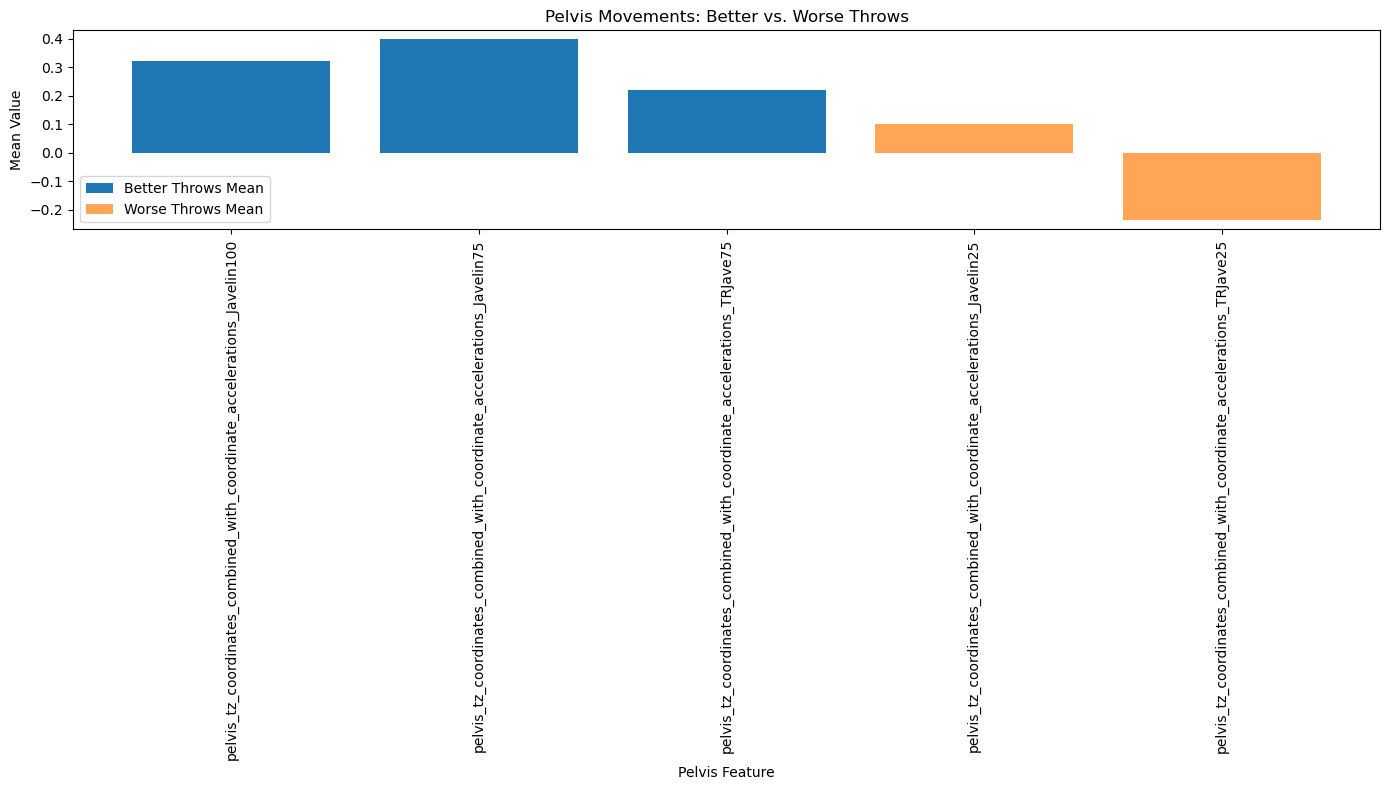

In [50]:
import matplotlib.pyplot as plt

# Identify the pelvis-related features
pelvis_features = [col for col in mean_comparison.index if 'pelvis' in col.lower()]

# Filter the mean_comparison DataFrame to include only pelvis-related features
pelvis_comparison = mean_comparison.loc[pelvis_features]

# Create a bar plot comparing the means for better and worse throws
plt.figure(figsize=(14, 8))

# Plotting the values for better and worse throws
plt.bar(pelvis_comparison.index, pelvis_comparison['Better Throws Mean'], label='Better Throws Mean')
plt.bar(pelvis_comparison.index, pelvis_comparison['Worse Throws Mean'], label='Worse Throws Mean', alpha=0.7)

# Adding titles and labels
plt.title('Pelvis Movements: Better vs. Worse Throws')
plt.xlabel('Pelvis Feature')
plt.ylabel('Mean Value')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


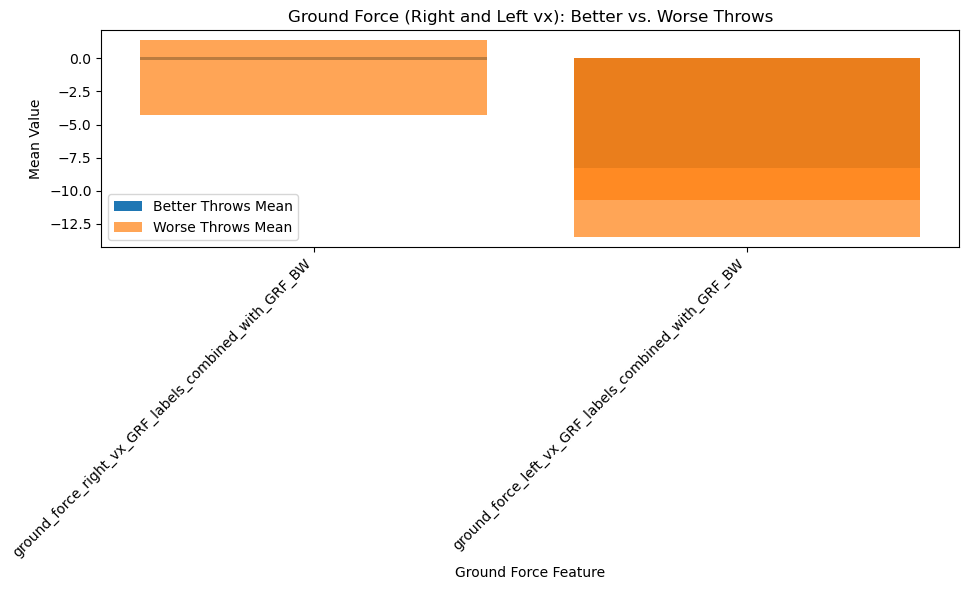

In [52]:
import matplotlib.pyplot as plt

# List of specific ground force features to analyze (without the throw labels)
ground_force_features = [
    'ground_force_right_vx_GRF_labels_combined_with_GRF_BW',
    'ground_force_left_vx_GRF_labels_combined_with_GRF_BW'
]

# Function to remove throw labels from the feature names
def remove_throw_labels(index):
    return index.str.replace(r'_Javelin\d+$|_TRJave\d+$', '', regex=True)

# Remove the throw labels from the index
mean_comparison.index = remove_throw_labels(mean_comparison.index)

# Filter the mean_comparison DataFrame to include only the specified ground force features
ground_force_comparison = mean_comparison.loc[ground_force_features]

# Create a bar plot comparing the means for better and worse throws
plt.figure(figsize=(10, 6))

# Plotting the values for better and worse throws
plt.bar(ground_force_comparison.index, ground_force_comparison['Better Throws Mean'], label='Better Throws Mean')
plt.bar(ground_force_comparison.index, ground_force_comparison['Worse Throws Mean'], label='Worse Throws Mean', alpha=0.7)

# Adding titles and labels
plt.title('Ground Force (Right and Left vx): Better vs. Worse Throws')
plt.xlabel('Ground Force Feature')
plt.ylabel('Mean Value')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

plt.show()


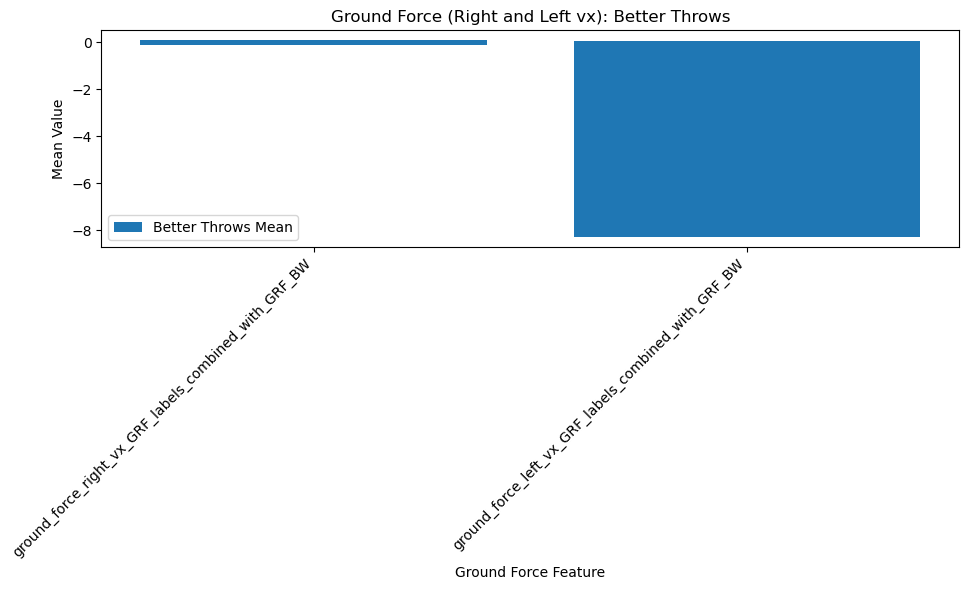

In [53]:
import matplotlib.pyplot as plt

# Function to remove throw labels from the feature names
def remove_throw_labels(index):
    return index.str.replace(r'_Javelin\d+$|_TRJave\d+$', '', regex=True)

# Remove the throw labels from the index
mean_comparison.index = remove_throw_labels(mean_comparison.index)

# Filter the mean_comparison DataFrame to include only the specified ground force features
ground_force_features = [
    'ground_force_right_vx_GRF_labels_combined_with_GRF_BW',
    'ground_force_left_vx_GRF_labels_combined_with_GRF_BW'
]
ground_force_comparison = mean_comparison.loc[ground_force_features]

# Now, only plot the values for the better throws
plt.figure(figsize=(10, 6))

# Plotting the values for better throws only
plt.bar(ground_force_comparison.index, ground_force_comparison['Better Throws Mean'], label='Better Throws Mean')

# Adding titles and labels
plt.title('Ground Force (Right and Left vx): Better Throws')
plt.xlabel('Ground Force Feature')
plt.ylabel('Mean Value')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


In [71]:
import pandas as pd
import numpy as np
import os

# Function to load and combine data, now adding throw_name as a column and ensuring unique column names
def load_combined_data(base_path, filenames, throw_name):
    data_frames = []
    for file in filenames:
        file_path = os.path.join(base_path, file)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, header=None)
            feature_name = os.path.splitext(os.path.basename(file))[0]
            # Avoid redundant labels and ensure uniqueness
            headers = df.iloc[:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
            if df.iloc[0, 1] == 0.0:
                headers = df.iloc[1:, 0].apply(lambda x: f"{x}_{feature_name}_{throw_name}").tolist()
                data = df.iloc[1:, 1:].transpose().reset_index(drop=True)
            else:
                data = df.iloc[:, 1:].transpose().reset_index(drop=True)
            data.columns = headers
            data['throw_name'] = throw_name  # Add throw_name as a column
            data_frames.append(data)
    combined_data = pd.concat(data_frames, axis=1)
    
    # Ensure all column names are unique by adding a suffix if necessary
    combined_data.columns = pd.Series(combined_data.columns).astype(str) + pd.Series(range(len(combined_data.columns))).astype(str)
    
    return combined_data

# Function to combine data for all throws, with throw_name column added
def combine_data_for_all_throws(base_paths, filenames):
    combined_data = {}
    for path in base_paths:
        throw_name = os.path.basename(os.path.dirname(path))
        combined_data[throw_name] = load_combined_data(path, filenames, throw_name)
    return combined_data

# Load and preprocess the data
all_data = combine_data_for_all_throws(base_paths, feature_groups['All'])

# Concatenate the data while ensuring unique column names
all_data_list = []
for throw_name, temp_data in all_data.items():
    temp_data['throw_name'] = throw_name  # Ensure throw_name column is added
    temp_data['distance'] = throw_distances.get(throw_name, np.nan)  # Add the target distance
    all_data_list.append(temp_data)

all_data_combined = pd.concat(all_data_list, axis=0, ignore_index=True)

# Now the 'throw_name' column should be available for filtering by throw type
better_throws = ['Javelin75', 'Javelin100', 'TRJave75']
worse_throws = ['Javelin25', 'TRJave25']

# Filter data based on throw_name
better_throw_data = all_data_combined[all_data_combined['throw_name'].isin(better_throws)]
worse_throw_data = all_data_combined[all_data_combined['throw_name'].isin(worse_throws)]

# Filter data based on throw_name
better_throw_data = all_data_combined[all_data_combined['throw_name'].isin(better_throws)]
worse_throw_data = all_data_combined[all_data_combined['throw_name'].isin(worse_throws)]

# Select only numeric columns for mean calculation
better_throw_data_numeric = better_throw_data.select_dtypes(include=[np.number])
worse_throw_data_numeric = worse_throw_data.select_dtypes(include=[np.number])

# Calculate means
better_means = better_throw_data_numeric.mean()
worse_means = worse_throw_data_numeric.mean()

# Example output: Compare means for better vs. worse throws
mean_comparison = pd.DataFrame({'Better Throws Mean': better_means, 'Worse Throws Mean': worse_means})
mean_comparison['Difference'] = mean_comparison['Better Throws Mean'] - mean_comparison['Worse Throws Mean']

# Display the result
print(mean_comparison)



                                                    Better Throws Mean  \
ground_force_right_px_COP_labels_combined_with_...                 NaN   
ground_force_right_py_COP_labels_combined_with_...                 NaN   
ground_force_right_pz_COP_labels_combined_with_...                 NaN   
ground_force_left_px_COP_labels_combined_with_C...                 NaN   
ground_force_left_py_COP_labels_combined_with_C...                 NaN   
...                                                                ...   
arm_rot_r_coordinates_combined_with_coordinate_...           18.141234   
elbow_flex_l_coordinates_combined_with_coordina...            3.740589   
elbow_flex_r_coordinates_combined_with_coordina...           -1.205769   
pro_sup_l_coordinates_combined_with_coordinate_...            1.516493   
pro_sup_r_coordinates_combined_with_coordinate_...           -0.888400   

                                                    Worse Throws Mean  \
ground_force_right_px_COP_labels_combi

In [76]:
def make_unique_columns(df):
    # Create a set to track column names
    seen = set()
    # New list to hold unique column names
    new_columns = []
    
    for col in df.columns:
        new_col = col
        counter = 1
        # Append a counter until the column name is unique
        while new_col in seen:
            new_col = f"{col}_{counter}"
            counter += 1
        # Add the new unique column name to the set and list
        seen.add(new_col)
        new_columns.append(new_col)
    
    df.columns = new_columns
    return df

# Apply the unique column function
better_throw_data_torque_power = make_unique_columns(better_throw_data_torque_power)
worse_throw_data_torque_power = make_unique_columns(worse_throw_data_torque_power)

# Convert all data to numeric, coercing errors to NaN
better_throw_data_torque_power = better_throw_data_torque_power.apply(pd.to_numeric, errors='coerce')
worse_throw_data_torque_power = worse_throw_data_torque_power.apply(pd.to_numeric, errors='coerce')

# Drop any columns that are entirely non-numeric (if any)
better_throw_data_torque_power = better_throw_data_torque_power.dropna(axis=1, how='all')
worse_throw_data_torque_power = worse_throw_data_torque_power.dropna(axis=1, how='all')

# Calculate means
better_means_torque_power = better_throw_data_torque_power.mean()
worse_means_torque_power = worse_throw_data_torque_power.mean()

# Compare means
torque_power_comparison = pd.DataFrame({
    'Better Throws Mean': better_means_torque_power,
    'Worse Throws Mean': worse_means_torque_power
})
torque_power_comparison['Difference'] = torque_power_comparison['Better Throws Mean'] - torque_power_comparison['Worse Throws Mean']

# Display the result
print(torque_power_comparison)


                  Better Throws Mean  Worse Throws Mean    Difference
0_powers                9.005820e+01       1.000526e+02 -9.994431e+00
0_powers_1             -2.122910e+01       2.947915e+01 -5.070825e+01
0_powers_2              9.755392e+01       9.755392e+01  0.000000e+00
0_powers_3              2.084872e+01      -5.289049e+00  2.613777e+01
0_powers_4              9.803103e+01                NaN           NaN
0_powers_5              6.625681e+00                NaN           NaN
0_torques_BWht          9.006085e+01       1.000550e+02 -9.994177e+00
0_torques_BWht_1       -3.229830e-08       3.677861e-10 -3.266609e-08
0_torques_BWht_2        9.755637e+01       9.755637e+01  0.000000e+00
0_torques_BWht_3       -1.439917e-09       1.548204e-10 -1.594738e-09
0_torques_BWht_4        9.803251e+01                NaN           NaN
0_torques_BWht_5        4.292718e-09                NaN           NaN


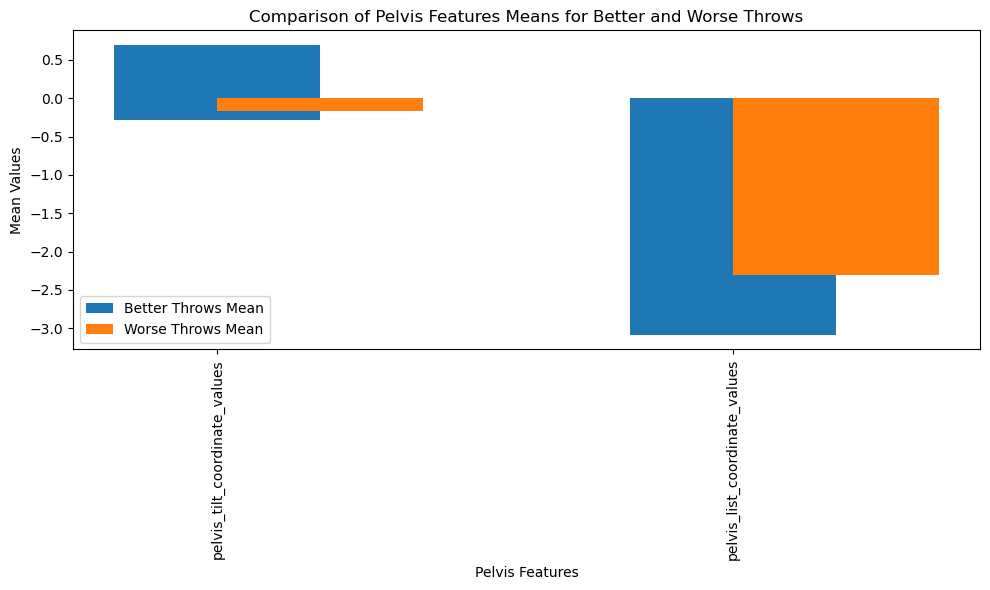

In [79]:
# Identify the relevant columns for pelvis_list_coordinate_values and pelvis_tilt_coordinate_values
pelvis_columns = ['pelvis_list_coordinate_values', 'pelvis_tilt_coordinate_values']

# Filter the dataset to include only these columns
matching_columns = [col for col in better_throw_data.columns if any(pc in col for pc in pelvis_columns)]
better_throw_data_pelvis = better_throw_data.loc[:, matching_columns]
worse_throw_data_pelvis = worse_throw_data.loc[:, matching_columns]

# Remove throw-specific suffixes for comparison
better_throw_data_pelvis.columns = better_throw_data_pelvis.columns.map(strip_throw_suffix)
worse_throw_data_pelvis.columns = worse_throw_data_pelvis.columns.map(strip_throw_suffix)

# Drop non-numeric columns
better_throw_data_pelvis = better_throw_data_pelvis.apply(pd.to_numeric, errors='coerce')
worse_throw_data_pelvis = worse_throw_data_pelvis.apply(pd.to_numeric, errors='coerce')

# Calculate means
better_means_pelvis = better_throw_data_pelvis.mean()
worse_means_pelvis = worse_throw_data_pelvis.mean()

# Compare means
pelvis_comparison = pd.DataFrame({
    'Better Throws Mean': better_means_pelvis,
    'Worse Throws Mean': worse_means_pelvis
})
pelvis_comparison['Difference'] = pelvis_comparison['Better Throws Mean'] - pelvis_comparison['Worse Throws Mean']

# Visualize the comparison
plt.figure(figsize=(10, 6))
plt.bar(pelvis_comparison.index, pelvis_comparison['Better Throws Mean'], width=0.4, label='Better Throws Mean', align='center')
plt.bar(pelvis_comparison.index, pelvis_comparison['Worse Throws Mean'], width=0.4, label='Worse Throws Mean', align='edge')

# Add labels and title
plt.xlabel('Pelvis Features')
plt.ylabel('Mean Values')
plt.title('Comparison of Pelvis Features Means for Better and Worse Throws')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


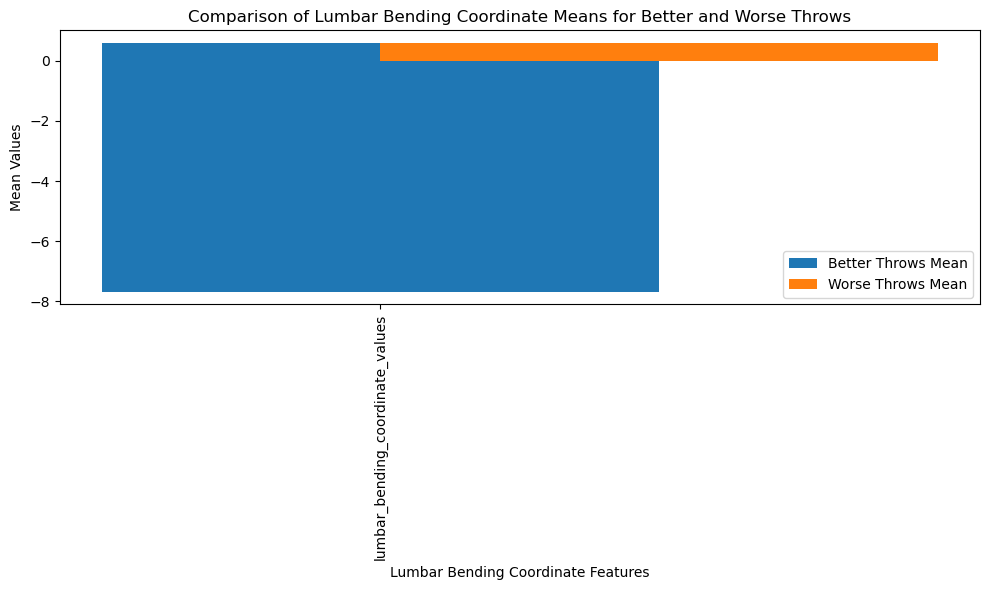

In [81]:
# Identify the relevant column for lumbar_bending_coordinate_values
lumbar_column = 'lumbar_bending_coordinate_values'

# Filter the dataset to include only this column
matching_columns = [col for col in better_throw_data.columns if lumbar_column in col]
better_throw_data_lumbar = better_throw_data.loc[:, matching_columns]
worse_throw_data_lumbar = worse_throw_data.loc[:, matching_columns]

# Remove throw-specific suffixes for comparison
better_throw_data_lumbar.columns = better_throw_data_lumbar.columns.map(strip_throw_suffix)
worse_throw_data_lumbar.columns = worse_throw_data_lumbar.columns.map(strip_throw_suffix)

# Drop non-numeric columns (if any)
better_throw_data_lumbar = better_throw_data_lumbar.apply(pd.to_numeric, errors='coerce')
worse_throw_data_lumbar = worse_throw_data_lumbar.apply(pd.to_numeric, errors='coerce')

# Calculate means
better_means_lumbar = better_throw_data_lumbar.mean()
worse_means_lumbar = worse_throw_data_lumbar.mean()

# Compare means
lumbar_comparison = pd.DataFrame({
    'Better Throws Mean': better_means_lumbar,
    'Worse Throws Mean': worse_means_lumbar
})
lumbar_comparison['Difference'] = lumbar_comparison['Better Throws Mean'] - lumbar_comparison['Worse Throws Mean']

# Visualize the comparison
plt.figure(figsize=(10, 6))
plt.bar(lumbar_comparison.index, lumbar_comparison['Better Throws Mean'], width=0.4, label='Better Throws Mean', align='center')
plt.bar(lumbar_comparison.index, lumbar_comparison['Worse Throws Mean'], width=0.4, label='Worse Throws Mean', align='edge')

# Add labels and title
plt.xlabel('Lumbar Bending Coordinate Features')
plt.ylabel('Mean Values')
plt.title('Comparison of Lumbar Bending Coordinate Means for Better and Worse Throws')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


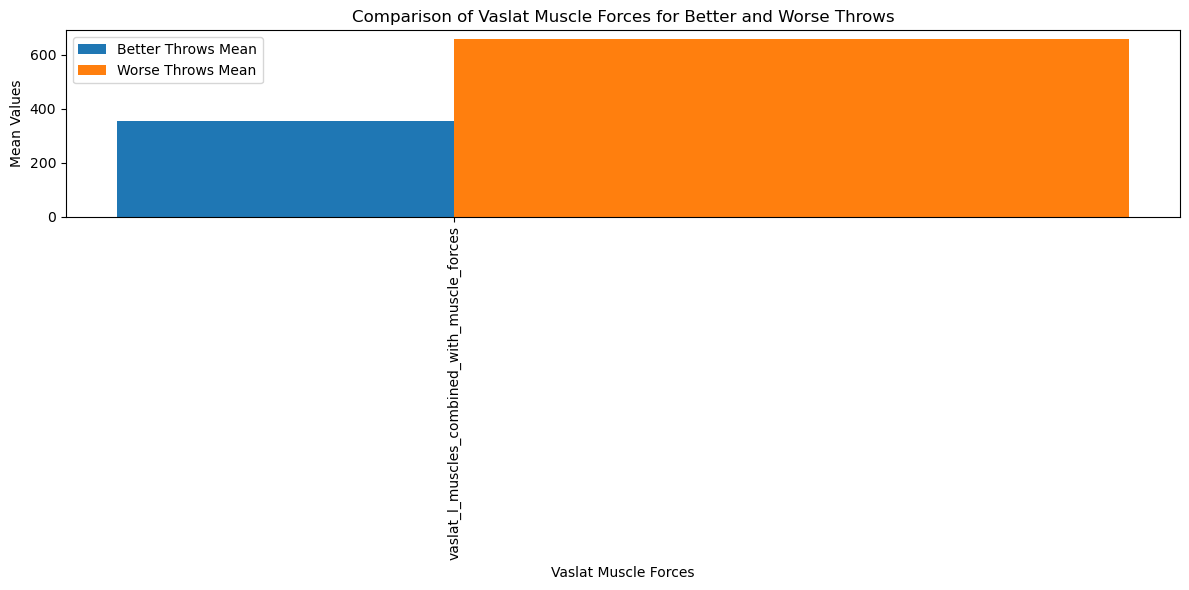

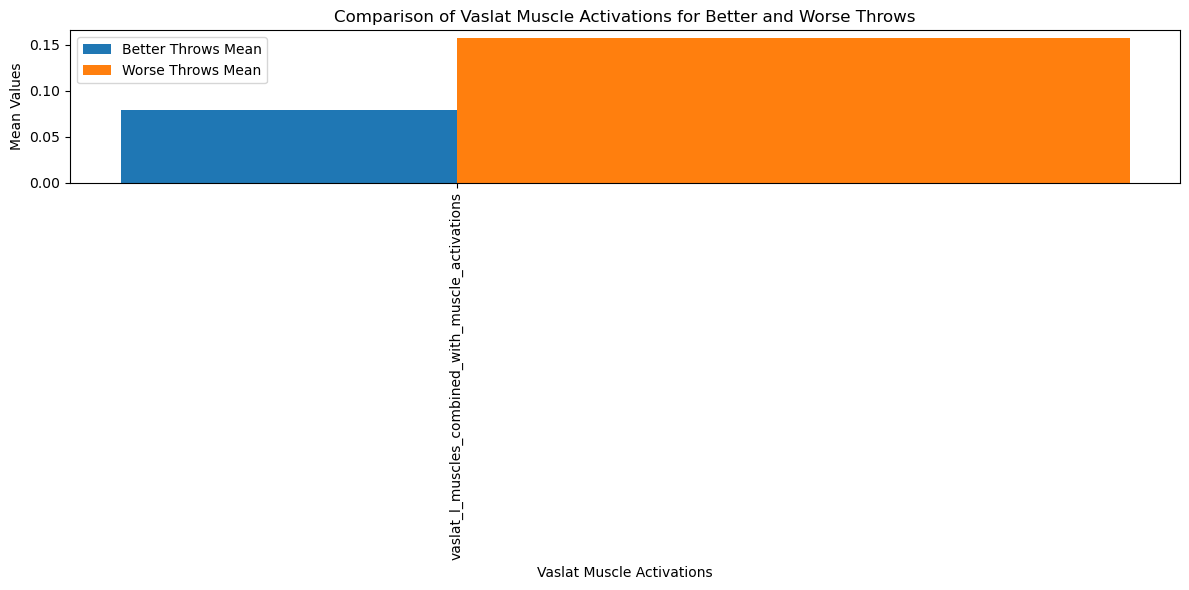

In [83]:
# Identify the relevant columns for vaslat_l_muscles_combined_with_muscle_forces and muscle_activations
forces_feature = 'vaslat_l_muscles_combined_with_muscle_forces'
activations_feature = 'vaslat_l_muscles_combined_with_muscle_activations'

# Filter the dataset to include only these columns
forces_columns = [col for col in better_throw_data.columns if forces_feature in col]
activations_columns = [col for col in better_throw_data.columns if activations_feature in col]

better_throw_data_forces = better_throw_data.loc[:, forces_columns]
worse_throw_data_forces = worse_throw_data.loc[:, forces_columns]

better_throw_data_activations = better_throw_data.loc[:, activations_columns]
worse_throw_data_activations = worse_throw_data.loc[:, activations_columns]

# Remove throw-specific suffixes for comparison
better_throw_data_forces.columns = better_throw_data_forces.columns.map(strip_throw_suffix)
worse_throw_data_forces.columns = worse_throw_data_forces.columns.map(strip_throw_suffix)

better_throw_data_activations.columns = better_throw_data_activations.columns.map(strip_throw_suffix)
worse_throw_data_activations.columns = worse_throw_data_activations.columns.map(strip_throw_suffix)

# Drop non-numeric columns (if any)
better_throw_data_forces = better_throw_data_forces.apply(pd.to_numeric, errors='coerce')
worse_throw_data_forces = worse_throw_data_forces.apply(pd.to_numeric, errors='coerce')

better_throw_data_activations = better_throw_data_activations.apply(pd.to_numeric, errors='coerce')
worse_throw_data_activations = worse_throw_data_activations.apply(pd.to_numeric, errors='coerce')

# Calculate means
better_means_forces = better_throw_data_forces.mean()
worse_means_forces = worse_throw_data_forces.mean()

better_means_activations = better_throw_data_activations.mean()
worse_means_activations = worse_throw_data_activations.mean()

# Compare means for forces
forces_comparison = pd.DataFrame({
    'Better Throws Mean': better_means_forces,
    'Worse Throws Mean': worse_means_forces
})
forces_comparison['Difference'] = forces_comparison['Better Throws Mean'] - forces_comparison['Worse Throws Mean']

# Compare means for activations
activations_comparison = pd.DataFrame({
    'Better Throws Mean': better_means_activations,
    'Worse Throws Mean': worse_means_activations
})
activations_comparison['Difference'] = activations_comparison['Better Throws Mean'] - activations_comparison['Worse Throws Mean']

# Visualization for forces
plt.figure(figsize=(12, 6))
plt.bar(forces_comparison.index, forces_comparison['Better Throws Mean'], width=0.4, label='Better Throws Mean', align='center')
plt.bar(forces_comparison.index, forces_comparison['Worse Throws Mean'], width=0.4, label='Worse Throws Mean', align='edge')

# Add labels and title for forces
plt.xlabel('Vaslat Muscle Forces')
plt.ylabel('Mean Values')
plt.title('Comparison of Vaslat Muscle Forces for Better and Worse Throws')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Visualization for activations
plt.figure(figsize=(12, 6))
plt.bar(activations_comparison.index, activations_comparison['Better Throws Mean'], width=0.4, label='Better Throws Mean', align='center')
plt.bar(activations_comparison.index, activations_comparison['Worse Throws Mean'], width=0.4, label='Worse Throws Mean', align='edge')

# Add labels and title for activations
plt.xlabel('Vaslat Muscle Activations')
plt.ylabel('Mean Values')
plt.title('Comparison of Vaslat Muscle Activations for Better and Worse Throws')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()
